In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import patsy

import statsmodels.formula.api as smf
import statsmodels.api as sm

from joblib import Parallel, delayed

%matplotlib inline


In [2]:
plt.style.use('seaborn-whitegrid')
font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
plt.rc('lines', linewidth=4)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend', fontsize=8)


## $UWXYZ$
Let's start by building intuition around a simulation and the implications of the invertibility of $P(W|Z,x)$.<br> We construct conditional probability tables based on the following steps, where $i$ is an index referencing a specific draw of the tuple $(U_i, W_i, X_i, Y_i, Z_i)$. We will take $n$ such draws.
* $U_i \sim Ber(\phi)$, $\phi = 0.5$
* $W_i \sim Ber(\phi + (u_i - \frac{1}{2})\delta_{UW})$
* $Z_i \sim Ber(\phi + (u_i - \frac{1}{2})\delta_{UZ})$
* $X_i \sim Ber(\phi + (u_i - \frac{1}{2})\delta_{UX} + (z_i - \frac{1}{2})\delta_{ZX})$
* $Y_i \sim Ber(\phi + (u_i - \frac{1}{2})\delta_{UY} + (w_i - \frac{1}{2})\delta_{WY} + (x_i - \frac{1}{2})\delta_{XY})$

We will vary the set of $\delta$ parameters and compute the corresponding condition number of $P(W|Z,x)$.


In [3]:
# For a given set of parameters that specifies the DGP, return a dataframe of n draws.
def simulate_UWXYZ(deltas, phi=0.5, n=int(1e6) ):

    ## Draw U
    if phi<0.0 or phi>1.0:
        print('phi is out of bounds.')
        return
    df = pd.DataFrame({'u':np.random.binomial(n=1, p=phi, size=n)})

    ## Draw W, which is dependent on U.
    probs = phi+(df['u']-1.0/2)*deltas['UW']
    if probs.min()<0.0 or probs.max()>1.0:
        print('probs for W are out of bounds.')
        return
    df['w'] = np.random.binomial(n=1, p=probs, size=n)
    
    ## Draw Z, which is dependent on U.
    probs = phi+(df['u']-1.0/2)*deltas['UZ']
    if probs.min()<0.0 or probs.max()>1.0:
        print('probs for Z are out of bounds.')
        return
    df['z'] = np.random.binomial(n=1, p=probs, size=n)

    ## Draw X, which is dependent on U and Z (and optionally, W)
    probs = phi+(df['u']-1.0/2)*deltas['UX']+(df['z']-1.0/2)*deltas['ZX']+(df['w']-1.0/2)*deltas['WX']
    if probs.min()<0.0 or probs.max()>1.0:
        print('probs for X are out of bounds.')
        return
    df['x'] = np.random.binomial(n=1, p=probs, size=n)
    
    ## Draw Y, which is dependent on U, W, and X (and optionally, Z)
    probs = phi+(df['u']-1.0/2)*deltas['UY']+(df['w']-1.0/2)*deltas['WY']+(df['x']-1.0/2)*deltas['XY']+(df['z']-1.0/2)*deltas['ZY']
    if probs.min()<0.0 or probs.max()>1.0:
        print('probs for Y are out of bounds.')
        return
    df['y'] = np.random.binomial(n=1, p=probs, size=n)

    return(df)

deltas = {'UW':0.25,
          'UX':0.25,
          'UY':0.25,
          'UZ':0.25,
          'WY':0.25,
          'XY':0.25,
          'ZX':0.25,
          'WX':0,
          'ZY':0 }
df_sim1 = simulate_UWXYZ(deltas = deltas)
df_sim1.groupby(['u','w','z','x']).mean().apply(lambda x: np.round(x,3))


y
u w z x       
0 0 0 0  0.125
      1  0.373
    1 0  0.123
      1  0.374
  1 0 0  0.376
      1  0.625
    1 0  0.372
      1  0.624
1 0 0 0  0.373
      1  0.621
    1 0  0.379
      1  0.626
  1 0 0  0.627
      1  0.875
    1 0  0.625
      1  0.876

In [4]:
def calculate_condition_number(df):
    
    X = 'x'
    # proxies
    W = 'w'; W_val = 1
    Z = 'z'; Z_val = 1

    # P(W | Z, x) represents two matrices, one for each value of x
    def calculate_condition_number_given_x(df, X_val):
        # p(W | X, Z=0)
        pWgXZ0 = np.bincount(df[(df[X]==X_val) & (df[Z]!=Z_val)][W]==W_val)
        pWgXZ0 = pWgXZ0 / pWgXZ0.sum()

        # p(W | X, Z=1)
        pWgXZ1 = np.bincount(df[(df[X]==X_val) & (df[Z]==Z_val)][W]==W_val)
        pWgXZ1 = pWgXZ1 / pWgXZ1.sum()

        pWZx = np.stack((pWgXZ0, pWgXZ1), axis=-1)
        return(np.linalg.cond(pWZx))
    
    condition_numbers = [calculate_condition_number_given_x(df, X_val) for X_val in [0,1]]

    return(max(condition_numbers) )

print('%.2f'%calculate_condition_number(df_sim1) )


25.28


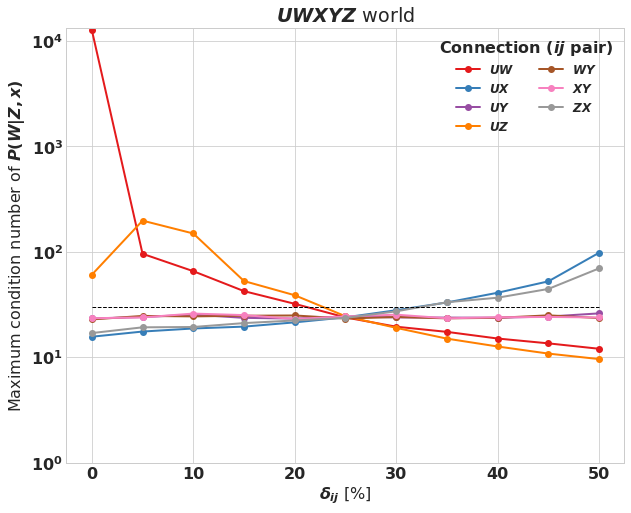

In [5]:
## Do a sweep of condition numbers

delta_names = ['UW', 'UX', 'UY', 'UZ', 'WY', 'XY', 'ZX']
value_scan = np.linspace(0,0.50,11)
base_deltas = {'UW':0.25,
               'UX':0.25,
               'UY':0.25,
               'UZ':0.25,
               'WY':0.25,
               'XY':0.25,
               'ZX':0.25,
               'WX':0,
               'ZY':0 }

def do_condition_number_trial(delta_name, base_deltas, delta_value):
    trial_deltas = base_deltas.copy()
    trial_deltas[delta_name] = delta_value
    return( delta_name, 100.0*delta_value, calculate_condition_number(simulate_UWXYZ(trial_deltas)) )

exp_list = Parallel(n_jobs=-1, max_nbytes=None)\
    (delayed(do_condition_number_trial)(delta_name, base_deltas, value)\
     for delta_name in delta_names for value in value_scan)

df_exp = pd.DataFrame(exp_list,
                      columns=['delta_name','delta_value_pct','condition_number'])

## Plot that compares the two approaches

fig, ax = plt.subplots(1,1,figsize=(10,8))

for index, delta_name in enumerate(delta_names):

    df_i = df_exp.loc[df_exp['delta_name']==delta_name]

    ax.plot(df_i['delta_value_pct'], df_i['condition_number'],
            linewidth=2, marker='.', linestyle='-', markersize=10, markeredgewidth=2,
            label = '$%s$'%delta_name.upper(),
            color=plt.cm.Set1(np.linspace(0,1,len(delta_names)))[index]
           )

ax.plot(df_i['delta_value_pct'], np.ones_like(df_i['delta_value_pct'])*30.0, '--', linewidth=1, color='black')

ax.set_ylabel('Maximum condition number of $P(W | Z, x)$')
plt.yscale('log')
ax.set_ylim([1, df_exp['condition_number'].max()*1.05])
ax.set_xlabel('$\delta_{ij}$ [%]')
ax.set_title('$UWXYZ$ world')
ax.legend(loc='best',fontsize=12,title='Connection ($ij$ pair)', ncol=2)

plt.savefig('condition_number.png', dpi=300)
plt.show()


## Bias when breaking the structure of $UWXYZ$

The real-world has arrows everywhere. Here, we extend the DAG and its corresponding simulation by adding a connection from $W$ to $X$. This modified dependency is encoded as:
* $X_i \sim Ber(\phi + (u_i - \frac{1}{2})\delta_{UX} + (z_i - \frac{1}{2})\delta_{ZX}) + (w_i - \frac{1}{2})\delta_{WX})$

The other steps are unmodified. We vary $\delta_{WX}$ while holding the other $\delta$s constant, and estimate the relative bias in extracting the ATE under both negative controls and regression estimators.


In [6]:
## Let's estimate the true ATE from the simulation itself with the following function.

def calculate_true_ate(df):
    
    def delta_p_cond(group, n_obs):
        group_frac = np.sum(group['count'])*1.0/n_obs
        if group['x'].unique().size < 2:
            delta_p = 0.0
        else:
            delta_p = group.loc[group['x']==1,'mean'].iloc[0]-group.loc[group['x']==0,'mean'].iloc[0]
        return( pd.Series([group_frac,delta_p], index=['group_frac','delta_p'])  )

    exog_cols = [i for i in df.columns.to_list() if i!='y']
    exog_cols_minus_x = [i for i in exog_cols if i!='x']
    
    true_ate = \
        df.groupby(exog_cols)\
            .agg(['count','mean'])['y']\
            .reset_index()\
            .groupby(exog_cols_minus_x)\
            .apply(delta_p_cond, df.shape[0])\
            .reset_index()\
            .apply(lambda x: x['group_frac']*x['delta_p'], axis=1)\
            .sum()
    return(true_ate)

print('True ATEs:\nEmpirical is %.2f p.p. Intended is %.2f p.p.'%
      (calculate_true_ate(df_sim1)*100, base_deltas['XY']*100) )


True ATEs:
Empirical is 24.90 p.p. Intended is 25.00 p.p.


In [7]:
## Now, let's deploy the negative controls estimator and see how it recovers the true ATE.

def calculate_ate_negative_controls(df):
    
    X = 'x'
    Y = 'y'
    # proxies
    W = 'w'; W_val = 1
    Z = 'z'; Z_val = 1

    def calculate_pYdoX(df, X_val):
        # p(Y | X, Z=0)
        pYgXZ0 = np.bincount(df[(df[X]==X_val) & (df[Z]!=Z_val)][Y])
        pYgXZ0 = pYgXZ0 / pYgXZ0.sum()

        # p(Y | X, Z=1)
        pYgXZ1 = np.bincount(df[(df[X]==X_val) & (df[Z]==Z_val)][Y])
        pYgXZ1 = pYgXZ1 / pYgXZ1.sum()

        # p(W)
        pW = np.bincount(df[W]==W_val)
        pW = pW / pW.sum()

        # p(W | X, Z=0)
        pWgXZ0 = np.bincount(df[(df[X]==X_val) & (df[Z]!=Z_val)][W]==W_val)
        pWgXZ0 = pWgXZ0 / pWgXZ0.sum()

        # p(W | X, Z=1)
        pWgXZ1 = np.bincount(df[(df[X]==X_val) & (df[Z]==Z_val)][W]==W_val)
        pWgXZ1 = pWgXZ1 / pWgXZ1.sum()

        # Miao et al. adjustment (see paper)
        denom = pWgXZ0[0] - pWgXZ1[0]
        weight_0 = (pW[0] - pWgXZ1[0]) / denom
        weight_1 = (pWgXZ0[0] - pW[0]) / denom

        pYdoXmiao = pYgXZ0 * weight_0 + pYgXZ1 * weight_1

        # formula (5) using matrix inversion
        pWZx = np.stack((pWgXZ0, pWgXZ1), axis=-1)
        condition_number = np.linalg.cond(pWZx)
        weights = np.dot(np.linalg.pinv(pWZx), pW)

        pYdoXmiao_pinv = pYgXZ0 * weights[0] + pYgXZ1 * weights[1]
    
        return(pYdoXmiao_pinv[1], condition_number)
    
    pYdoX_results = [calculate_pYdoX(df, X_val) for X_val in [0,1]]
    
    condition_number = max([i[1] for i in pYdoX_results])
    negative_controls_ate = pYdoX_results[1][0] - pYdoX_results[0][0]
    return(negative_controls_ate, condition_number)

negative_controls_result = calculate_ate_negative_controls(df_sim1)

print('Method: relative bias (condition number), true ATE')
true_ate = calculate_true_ate(df_sim1)
print('Negative controls: %.1f%% (%.0f), %.1f%% ' % ((negative_controls_result[0]-true_ate)/true_ate*100,
                                                     negative_controls_result[1], true_ate*100 ) )


Method: relative bias (condition number), true ATE
Negative controls: 0.2% (25), 24.9% 


In [8]:
def calculate_ate_regression(df, formula='y ~ 1 + w + x + z', family=sm.families.Binomial()):
    
    model = smf.glm(formula=formula, data=df, family=family )
    model_result = model.fit(use_t=1)
    #print(model_result.summary())
    
    ##calculate ATE with 95% CI
    ones_vector  = model_result.params.index!='x'
    zeros_vector = model_result.params.index=='x'
    
    params_mid = model_result.params
    params_lower = model_result.params * ones_vector + model_result.conf_int()[0] * zeros_vector
    params_upper = model_result.params * ones_vector + model_result.conf_int()[1] * zeros_vector

    result_list = []
    patsy_df = patsy.dmatrices(model.formula, df, return_type='dataframe')[1]
    for params_i in [params_mid, params_lower, params_upper]:
        patsy_df['x'] = 0
        p0 = model.predict(params_i, patsy_df, linear=False).mean()
        patsy_df['x'] = 1
        p1 = model.predict(params_i, patsy_df, linear=False).mean()
        result_list.append(p1-p0)

    return(result_list[0], result_list[0]-result_list[1], result_list[2]-result_list[0])

regression_comparison_results = {}
regression_comparison_results['LR'] = calculate_ate_regression(df_sim1)
regression_comparison_results['OLS'] = calculate_ate_regression(df_sim1, family=sm.families.Gaussian() )
regression_comparison_results['LR, with U'] = calculate_ate_regression(df_sim1, formula='y ~ 1 + u + w + x + z')

print('Method: relative bias (LB, UB)')
true_ate = calculate_true_ate(df_sim1)
for key, value in regression_comparison_results.items():
    print('%s: %.1f%% (-%.1f%%, %.1f%%)' % (key, (value[0]-true_ate)/true_ate*100,
                                            value[1]/true_ate*100, value[2]/true_ate*100))


Method: relative bias (LB, UB)
LR: 24.6% (-0.8%, 0.8%)
OLS: 24.8% (-0.7%, 0.7%)
LR, with U: 0.0% (-0.8%, 0.8%)


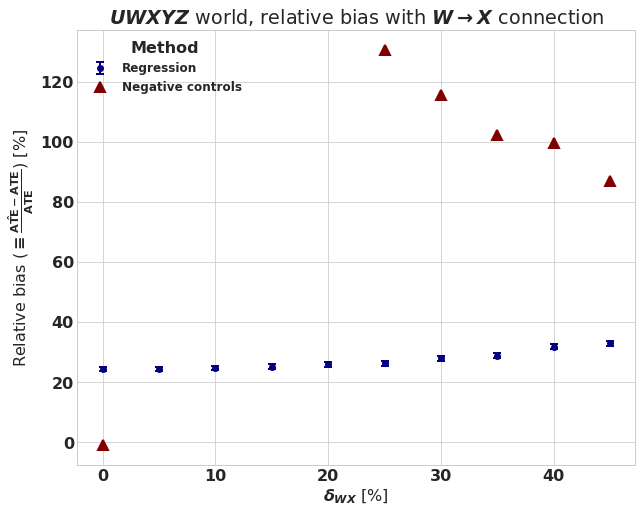

In [9]:
## Do a sweep of delta_WX

value_scan = np.linspace(0,0.50,11)
base_deltas = {'UW':0.25,
               'UX':0.25,
               'UY':0.25,
               'UZ':0.25,
               'WY':0.25,
               'XY':0.25,
               'ZX':0.25,
               'WX':0,
               'ZY':0 }

def do_UWXYZ_trial(delta_name, base_deltas, delta_value):
    trial_deltas = base_deltas.copy()
    trial_deltas[delta_name] = delta_value
    df_sim = simulate_UWXYZ(trial_deltas)
    if df_sim is None:
        return None
    regression_result = calculate_ate_regression(df_sim)
    negative_controls_result = calculate_ate_negative_controls(df_sim)
    true_ate = calculate_true_ate(df_sim)
    return(delta_name, delta_value*100, true_ate*100,
           (regression_result[0]-true_ate)/true_ate*100, regression_result[1]/true_ate*100, regression_result[2]/true_ate*100, 
           (negative_controls_result[0]-true_ate)/true_ate*100, negative_controls_result[1] )

exp_list = Parallel(n_jobs=-1, max_nbytes=None)\
    (delayed(do_UWXYZ_trial)('WX', base_deltas, value) for value in value_scan)

df_exp = pd.DataFrame(exp_list,
                      columns=['delta_name', 'delta_value_pct', 'true_ate_pct',
                               'reg_bias_pct', 'reg_bias_lb_pct', 'reg_bias_ub_pct',
                               'negative_controls_bias_pct', 'condition_number'] )

fig, ax = plt.subplots(1,1,figsize=(10,8))

#remove those points for which the empirical ATE and intended ATE do not closely match.
#this is due to coverage in all possible values of (u, w, x, z)
bias_list_well_supported = df_exp['true_ate_pct'].apply(lambda x: np.abs(x-base_deltas['XY']*100)<1.0)

ax.errorbar(df_exp.loc[bias_list_well_supported, 'delta_value_pct'],
            df_exp.loc[bias_list_well_supported, 'reg_bias_pct'],
            df_exp.loc[bias_list_well_supported, ['reg_bias_lb_pct','reg_bias_ub_pct']].to_numpy().T,
            linewidth=0, marker='.', markersize=10, capsize=4, elinewidth=2, markeredgewidth=2,
            label = 'Regression', color=plt.cm.jet(np.linspace(0,1,2))[0]
           )

#remove those point for which the matrix P(W | Z, x) is not invertible.
bias_list_well_conditioned = bias_list_well_supported & (df_exp['condition_number']<30)

ax.errorbar(df_exp.loc[bias_list_well_conditioned, 'delta_value_pct'],
            df_exp.loc[bias_list_well_conditioned, 'negative_controls_bias_pct'],
            linewidth=0, marker='^', linestyle='--', markersize=10, capsize=4, elinewidth=2, markeredgewidth=2,
            label = 'Negative controls',
            color=plt.cm.jet(np.linspace(0,1,2))[1]
           )

ax.set_ylabel('Relative bias ($\equiv \\frac{\^{\mathrm{ATE}} - \mathrm{ATE}}{\mathrm{ATE}}$) [%]')
#ax.set_ylim([-0.1,0.6])
ax.set_xlabel('$\delta_{WX}$ [%]')
ax.set_title('$UWXYZ$ world, relative bias with $W \\rightarrow X$ connection')
ax.legend(loc=2,fontsize=12,title='Method', ncol=1)

plt.savefig('bias_with_wx.png', dpi=200)
plt.show()


## Understanding the variance of the negative controls estimator
Next, we deploy many simulations with fixed graphical structure in order to understand the variance of the estimator. We compare to regression. We show that 
* Negative controls vs. regression can be thought of as a bias vs. variance trade-off.
* The variance of the negative controls estimator grows with condition number of $P(W|Z,x)$
* The condition number and relative bias are anti-correlated, meaning selection of $W$ and $Z$ to minimize condition number will induce some small bias into the estimator. 


/apps/python3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


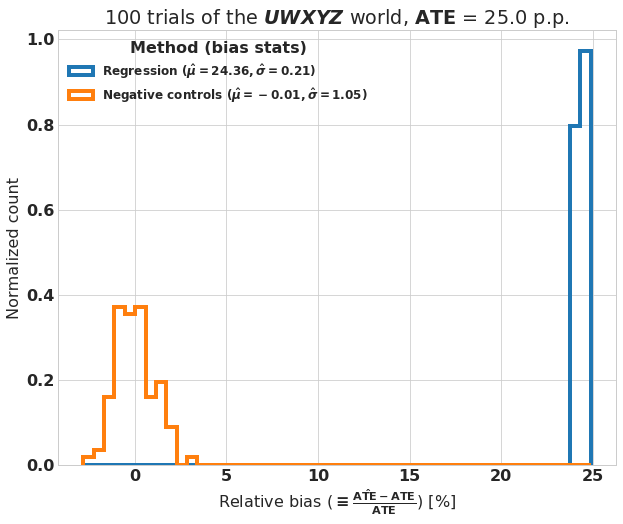

In [10]:
## do many draws with the base deltas, and quantify the distrubution of the absolute bias under do-calculus

n_trial = 100

value_scan = np.linspace(0,0.50,11)
base_deltas = {'UW':0.25,
               'UX':0.25,
               'UY':0.25,
               'UZ':0.25,
               'WY':0.25,
               'XY':0.25,
               'ZX':0.25,
               'WX':0,
               'ZY':0 }

exp_list = Parallel(n_jobs=-1, max_nbytes=None)\
    (delayed(do_UWXYZ_trial)('WX', base_deltas, 0) for i in range(n_trial))

df_exp = pd.DataFrame(exp_list,
                      columns=['delta_name', 'delta_value_pct', 'true_ate_pct',
                               'reg_bias_pct', 'reg_bias_lb_pct', 'reg_bias_ub_pct',
                               'negative_controls_bias_pct', 'condition_number'] )

fig, ax = plt.subplots(1,1,figsize=(10,8))

bins = np.linspace(df_exp[['reg_bias_pct','negative_controls_bias_pct']].values.min()-0.01,
                   df_exp[['reg_bias_pct','negative_controls_bias_pct']].values.max()+0.01,
                   50)

ax.hist(df_exp['reg_bias_pct'], bins=bins,
        density=True, histtype='step', linewidth=4,
        label='Regression ($\hat{\mu} = %.2f, \hat{\sigma} = %.2f$)'%
            (df_exp['reg_bias_pct'].mean(), df_exp['reg_bias_pct'].std())
       )

ax.hist(df_exp['negative_controls_bias_pct'], bins=bins,
        density=True, histtype='step', linewidth=4,
        label='Negative controls ($\hat{\mu} = %.2f, \hat{\sigma} = %.2f$)'%
            (df_exp['negative_controls_bias_pct'].mean(), df_exp['negative_controls_bias_pct'].std())
       )

## quick check of normality
if False:
    bins = np.linspace(-0.5,0.6,500)
    ax.plot(bins, norm.pdf(bins, np.mean(bias_list_reg)*100.0, np.std(bias_list_reg)*100.0))
    ax.plot(bins, norm.pdf(bins, np.mean(bias_list_doc)*100.0, np.std(bias_list_doc)*100.0))

ax.set_xlabel('Relative bias ($\equiv \\frac{\^{\mathrm{ATE}} - \mathrm{ATE}}{\mathrm{ATE}}$) [%]')
ax.set_ylabel('Normalized count')
ax.set_title('%d trials of the $UWXYZ$ world, $\mathrm{ATE}$ = %.1f p.p.'%
             (n_trial, df_exp['true_ate_pct'].iloc[0]) )
ax.legend(loc=2,fontsize=12,title='Method (bias stats)', ncol=1)

plt.show()


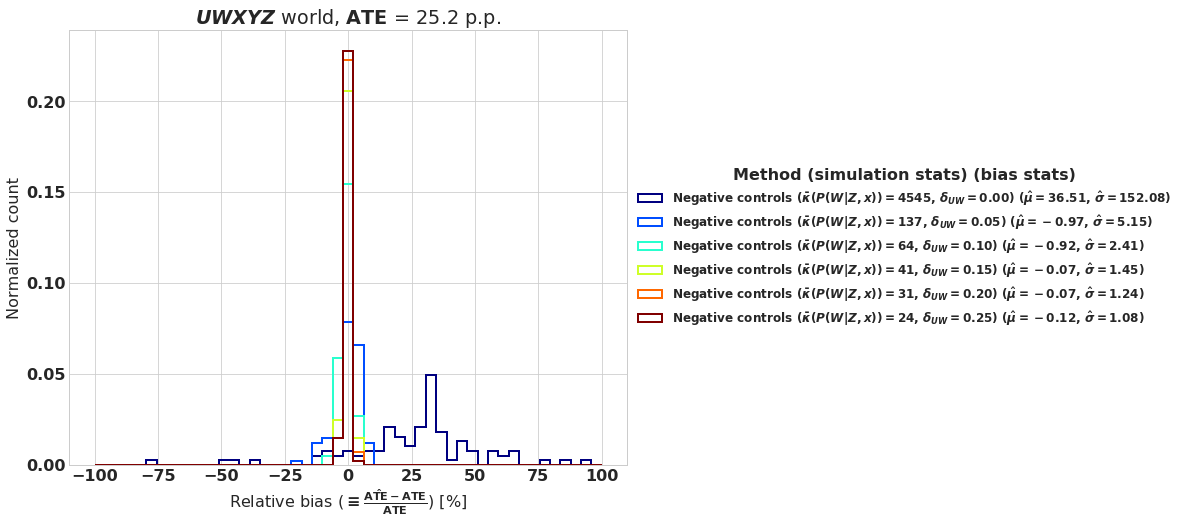

In [11]:
## do many draws with the base deltas, and quantify the distribution of the absolute bias under do-calculus.
## repeat this for differing values of delta_UW, which will cause the condition number to explode.

n_trial = 100
value_scan = np.linspace(0,0.25,6)
base_deltas = {'UW':0.25,
               'UX':0.25,
               'UY':0.25,
               'UZ':0.25,
               'WY':0.25,
               'XY':0.25,
               'ZX':0.25,
               'WX':0,
               'ZY':0 }

exp_list = Parallel(n_jobs=-1, max_nbytes=None)\
    (delayed(do_UWXYZ_trial)('UW', base_deltas, j) for i in range(n_trial) for j in value_scan)

df_exp = pd.DataFrame(exp_list,
                      columns=['delta_name', 'delta_value_pct', 'true_ate_pct',
                               'reg_bias_pct', 'reg_bias_lb_pct', 'reg_bias_ub_pct',
                               'negative_controls_bias_pct', 'condition_number'] )

fig, ax = plt.subplots(1,1,figsize=(10,8))

bins = np.linspace(df_exp[['reg_bias_pct','negative_controls_bias_pct']].values.min()-0.01,
                   df_exp[['reg_bias_pct','negative_controls_bias_pct']].values.max()+0.01,
                   50)
bins = np.linspace(-100, 100, 50)

df_summary_stats = pd.DataFrame(columns=['method','delta_UW','mean_condition_number','sigma_condition_number','mu','sigma'],
                                index=range(value_scan.size*2))

for index, value_i in enumerate(value_scan):

    filter_i = df_exp['delta_value_pct'].apply(lambda x: np.abs(x/100.0-value_i)<1e-8)
    
    mean_condition_number_i = df_exp.loc[filter_i, 'condition_number'].mean()
    sigma_condition_number_i = df_exp.loc[filter_i, 'condition_number'].std()
    mu_i = df_exp.loc[filter_i, 'reg_bias_pct'].mean()
    sigma_i = df_exp.loc[filter_i, 'reg_bias_pct'].std()
    df_summary_stats.loc[index*2] = ['regression', value_i, mean_condition_number_i, sigma_condition_number_i, mu_i, sigma_i]
    #ax.hist(df_exp.loc[filter_i, 'reg_bias_pct'],
    #        bins=bins, density=True, histtype='step', linewidth=2, linestyle = '--',
    #        label=r'Regression ($\delta_{UW}=%.2f$) ($\hat{\mu} = %.2f$, $\hat{\sigma} = %.2f$)'%
    #            (value_i, mu_i, sigma_i),
    #        color=plt.cm.jet(np.linspace(0,1,value_scan.size))[index]
    #       )

    mu_i = df_exp.loc[filter_i, 'negative_controls_bias_pct'].mean()
    sigma_i = df_exp.loc[filter_i, 'negative_controls_bias_pct'].std()
    df_summary_stats.loc[index*2+1] = ['negative_controls', value_i, mean_condition_number_i, sigma_condition_number_i, mu_i, sigma_i]
    ax.hist(df_exp.loc[df_exp['delta_value_pct'].apply(lambda x: np.abs(x/100.0-value_i)<1e-8), 'negative_controls_bias_pct'],
            bins=bins, density=True, histtype='step', linewidth=2, linestyle = '-',
            label=r'Negative controls ($\bar{\kappa}(P(W|Z,x))=%.0f$, $\delta_{UW}=%.2f$) ($\hat{\mu} = %.2f$, $\hat{\sigma} = %.2f$)'%
                (mean_condition_number_i, value_i, mu_i, sigma_i),
            color=plt.cm.jet(np.linspace(0,1,value_scan.size))[index]
           )

ax.set_xlabel('Relative bias ($\equiv \\frac{\^{\mathrm{ATE}} - \mathrm{ATE}}{\mathrm{ATE}}$) [%]')
ax.set_ylabel('Normalized count')
ax.set_title('$UWXYZ$ world, $\mathrm{ATE}$ = %.1f p.p.'%
             (df_exp['true_ate_pct'].iloc[0]) )
ax.legend(fontsize=12,title='Method (simulation stats) (bias stats)', ncol=1,
          loc='center left', bbox_to_anchor=(1, 0.5) )

plt.show()


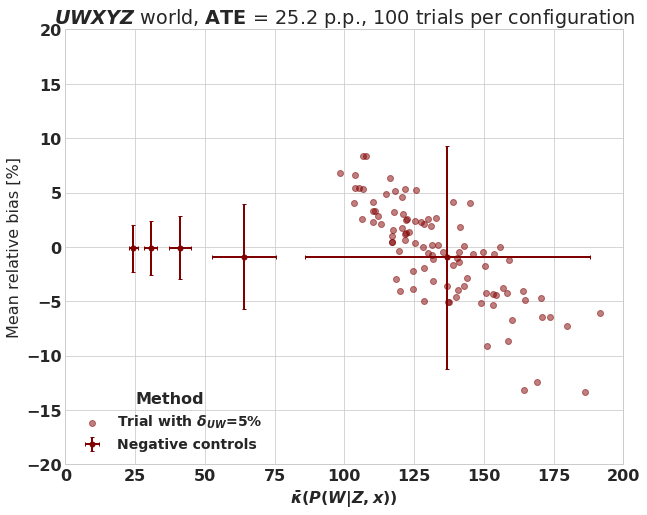

In [12]:
## Similar view, but exposing the relationship between condition number and bias.

fig, ax = plt.subplots(1,1,figsize=(10,8))

xmax = 200
df_summary_stats = df_summary_stats.loc[df_summary_stats['mean_condition_number']<xmax]

#ax.errorbar(df_summary_stats.loc[df_summary_stats['method']=='regression', 'mean_condition_number'],
#            df_summary_stats.loc[df_summary_stats['method']=='regression', 'mu'],
#            df_summary_stats.loc[df_summary_stats['method']=='regression', 'sigma']*2.0,
#            df_summary_stats.loc[df_summary_stats['method']=='regression', 'sigma_condition_number']*2.0,
#            label = 'Regression',
#            fmt='.', ms=10, elinewidth=2, capsize=2,
#            linewidth=0, linestyle = '-', color=plt.cm.jet(np.linspace(0,1,2))[0]
#           )
ax.errorbar(df_summary_stats.loc[df_summary_stats['method']=='negative_controls', 'mean_condition_number'],
            df_summary_stats.loc[df_summary_stats['method']=='negative_controls', 'mu'],
            df_summary_stats.loc[df_summary_stats['method']=='negative_controls', 'sigma']*2.0,
            df_summary_stats.loc[df_summary_stats['method']=='regression', 'sigma_condition_number']*2.0,
            label = 'Negative controls',
            fmt='.', ms=10, elinewidth=2, capsize=2,
            linewidth=0, linestyle = '-', color=plt.cm.jet(np.linspace(0,1,2))[1]
           )
for val_i in [5.]: #df_exp['delta_value_pct'].unique():
    df_i = df_exp.loc[df_exp['delta_value_pct']==val_i]
    ax.scatter(df_i['condition_number'], df_i['negative_controls_bias_pct'],
               color = plt.cm.jet(np.linspace(0,1,2))[1], alpha=0.5, label = 'Trial with $\delta_{UW}$=%.0f%%'%val_i )

#ax.set_xscale('log')
ax.set_xlim([0,xmax])
ax.set_xlabel(r'$\bar{\kappa}(P(W|Z,x))$')
ax.set_ylabel('Mean relative bias [%]')
ax.set_ylim([-20,20])
ax.set_title('$UWXYZ$ world, $\mathrm{ATE}$ = %.1f p.p., %d trials per configuration'%
             (df_exp['true_ate_pct'].iloc[0], n_trial ))
ax.legend(fontsize=14, title='Method', ncol=1, loc=3)

plt.show()


## Increasing the dimensionality of $\vec{U}$

The real-world has high-dimensionality $\vec{U}$, which we will take to be a vector of length $p$ with independent dimensions. We modify the simulation by constructing conditional probability tables based on the following steps, where $i = 0,...,n-1$ labels observations and $j = 0,...,p$ labels dimensions of $\vec{U}$ and of $\vec{\delta_{UV}}$, for $V \in \{W,X,Y,Z\}$.
* $U_{ij} \sim Ber(\phi)$, $\phi = 0.5$
* $W_i \sim Ber(\phi + (\vec{u_i} - \frac{1}{2}\vec{1})^\top \vec{\delta_{UW}})$
* $Z_i \sim Ber(\phi + (\vec{u_i} - \frac{1}{2}\vec{1})^\top \vec{\delta_{UZ}})$
* $X_i \sim Ber(\phi + (\vec{u_i} -  \frac{1}{2}\vec{1})^\top \vec{\delta_{UX}}) + (\vec{z_i} - \frac{1}{2}\vec{1})^\top \vec{\delta_{ZX}})$
* $Y_i \sim Ber(\phi + (\vec{u_i}  - \frac{1}{2}\vec{1})^\top \vec{\delta_{UY}}) + (\vec{w_i} - \frac{1}{2}\vec{1})^\top \vec{\delta_{WY}}) + (\vec{x_i} - \frac{1}{2}\vec{1})^\top \vec{\delta_{XY}})$

We will vary the set of $\delta$ parameters in two ways, and compute corresponding biases under both methods.
* Each element of $\vec{U}$ has equal impact on the other nodes $V$ in the graph, and we vary the dimensionality of $U$.
* For a fixed dimensionality of $\vec{U}$, we vary the impact that each element has.


In [13]:
# For a given set of parameters that specifies the DGP, return a dataframe of n draws.
def simulate_UWXYZ_vecU(deltas, dim_U, phi=0.5, n=int(1e6) ):

    ## Draw U as a vector
    if phi<0.0 or phi>1.0:
        print('phi is out of bounds.')
        return
    u_vec = np.random.binomial(n=1, p=phi, size=(n,dim_U))
    df = pd.DataFrame(u_vec, columns=['u_%d'%i for i in range(dim_U)])
    
    ## Draw W, which is dependent on U.
    probs = phi+np.dot((u_vec-1.0/2), deltas['UW'])
    if probs.min()<0.0 or probs.max()>1.0:
        print('probs for W are out of bounds.')
        return
    df['w'] = np.random.binomial(n=1, p=probs, size=n)
    
    ## Draw Z, which is dependent on U.
    probs = phi+np.dot((u_vec-1.0/2), deltas['UZ'])
    if probs.min()<0.0 or probs.max()>1.0:
        print('probs for Z are out of bounds.')
        return
    df['z'] = np.random.binomial(n=1, p=probs, size=n)

    ## Draw X, which is dependent on U and Z (and optionally, W)
    probs = phi+np.dot((u_vec-1.0/2), deltas['UX'])+(df['z']-1.0/2)*deltas['ZX']+(df['w']-1.0/2)*deltas['WX']
    if probs.min()<0.0 or probs.max()>1.0:
        print('probs for X are out of bounds.')
        return
    df['x'] = np.random.binomial(n=1, p=probs, size=n)
    
    ## Draw Y, which is dependent on U, W, and X (and optionally, Z)
    probs = phi+np.dot((u_vec-1.0/2), deltas['UX'])+(df['w']-1.0/2)*deltas['WY']+(df['x']-1.0/2)*deltas['XY']+(df['z']-1.0/2)*deltas['ZY']
    if probs.min()<0.0 or probs.max()>1.0:
        print('probs for Y are out of bounds.')
        return
    df['y'] = np.random.binomial(n=1, p=probs, size=n)

    return(df)

dim_U = 10
deltas = {'UW':np.ones(dim_U)*0.10,
          'UX':np.ones(dim_U)*0.05,
          'UY':np.ones(dim_U)*0.05,
          'UZ':np.ones(dim_U)*0.10,
          'WY':0.05,
          'XY':0.05,
          'ZX':0.05,
          'WX':0,
          'ZY':0 }
df_sim2 = simulate_UWXYZ_vecU(deltas = deltas, dim_U = dim_U)

print(df_sim2.head())
print('Max condition number = %.2f'%calculate_condition_number(df_sim2))


   u_0  u_1  u_2  u_3  u_4  u_5  u_6  u_7  u_8  u_9  w  z  x  y
0    0    1    1    0    1    1    1    1    1    0  1  0  1  1
1    1    0    1    1    0    0    0    0    0    1  0  0  0  0
2    1    0    0    0    0    0    0    0    0    0  0  0  0  0
3    1    0    1    1    0    0    0    0    0    0  1  0  1  0
4    1    1    0    0    1    0    0    0    1    0  1  1  1  1
Max condition number = 10.78


In [14]:
## Comparison of the two methods
def run_comparison_vec_U(df, deltas, dim_U):

    uy_str_list = []
    for i in range(dim_U):
        tmp_uy = df.groupby('u_%d'%i).mean()['y']
        uy_str_list.append( '%.1f' % ((tmp_uy[1]-tmp_uy[0])*100) )
    print('P(Y | U_j) - P(Y | ~U_j) = [%s] p.p.' % ', '.join(uy_str_list))
    
    true_ate = calculate_true_ate(df)
    print('True empirical ATE is %.2f p.p. Intended ATE is %.2f p.p.' % (true_ate*100, deltas['XY']*100) )

    regression_comparison_results = {}
    regression_comparison_results['LR'] = calculate_ate_regression(df)
    #regression_comparison_results['OLS'] = calculate_ate_regression(df, family=sm.families.Gaussian() )
    regression_comparison_results['LR, with U'] = calculate_ate_regression(df, formula='y ~ 1 + %s + w + x + z' % ' + '.join(['u_%d'%i for i in range(dim_U)]) )
    regression_comparison_results['LR, with U minus U_0'] = calculate_ate_regression(df, formula='y ~ 1 + %s + w + x + z' % ' + '.join(['u_%d'%i for i in range(1,dim_U)]) )

    print('Method: relative bias (LB, UB)')
    for key, value in regression_comparison_results.items():
        print('%s: %.1f%% (-%.1f%%, %.1f%%)' % (key, (value[0]-true_ate)/true_ate*100,
                                                value[1]/true_ate*100, value[2]/true_ate*100))

    negative_controls_result = calculate_ate_negative_controls(df)

    print('Method: relative bias (condition number), true ATE')
    print('Negative controls: %.1f%% (%.0f), %.2f p.p. ' % ((negative_controls_result[0]-true_ate)/true_ate*100,
                                                            negative_controls_result[1], true_ate*100 ) )
    
    return

print('Impact of U_j is constant for on V.')
dim_U = 10
deltas = {'UW':np.ones(dim_U)*0.10,
          'UX':np.ones(dim_U)*0.05,
          'UY':np.ones(dim_U)*0.05,
          'UZ':np.ones(dim_U)*0.10,
          'WY':0.05,
          'XY':0.05,
          'ZX':0.05,
          'WX':0,
          'ZY':0 }
df_sim2 = simulate_UWXYZ_vecU(deltas = deltas, dim_U = dim_U)
run_comparison_vec_U(df_sim2, deltas, dim_U)

print('\nImpact of U_j decreases like 1/(j+1) on all V.')
dim_U = 10
deltas = {'UW':np.array([0.20/(j+1) for j in range(dim_U)]),
          'UX':np.array([0.05/(j+1) for j in range(dim_U)]),
          'UY':np.array([0.05/(j+1) for j in range(dim_U)]),
          'UZ':np.array([0.20/(j+1) for j in range(dim_U)]),
          'WY':0.05,
          'XY':0.05,
          'ZX':0.05,
          'WX':0,
          'ZY':0 }
df_sim2 = simulate_UWXYZ_vecU(deltas = deltas, dim_U = dim_U)
run_comparison_vec_U(df_sim2, deltas, dim_U)

print('\nImpact of U_j decreases linearly on all V.')
dim_U = 10
deltas = {'UW':np.array([0.10*(1.0-1.0*j/dim_U) for j in range(dim_U)]),
          'UX':np.array([0.05*(1.0-1.0*j/dim_U) for j in range(dim_U)]),
          'UY':np.array([0.05*(1.0-1.0*j/dim_U) for j in range(dim_U)]),
          'UZ':np.array([0.10*(1.0-1.0*j/dim_U) for j in range(dim_U)]),
          'WY':0.05,
          'XY':0.05,
          'ZX':0.05,
          'WX':0,
          'ZY':0 }
df_sim2 = simulate_UWXYZ_vecU(deltas = deltas, dim_U = dim_U)
run_comparison_vec_U(df_sim2, deltas, dim_U)


Impact of U_j is constant for on V.
P(Y | U_j) - P(Y | ~U_j) = [5.8, 5.8, 5.7, 5.8, 5.8, 5.9, 5.7, 5.7, 5.7, 5.8] p.p.
True empirical ATE is 5.17 p.p. Intended ATE is 5.00 p.p.
Method: relative bias (LB, UB)
LR: 39.8% (-3.8%, 3.8%)
LR, with U: -0.1% (-3.8%, 3.8%)
LR, with U minus U_0: 4.9% (-3.8%, 3.8%)
Method: relative bias (condition number), true ATE
Negative controls: -0.9% (11), 5.17 p.p. 

Impact of U_j decreases like 1/(j+1) on all V.
P(Y | U_j) - P(Y | ~U_j) = [6.3, 3.1, 2.0, 1.5, 1.3, 0.9, 1.1, 0.9, 0.7, 0.4] p.p.
True empirical ATE is 4.95 p.p. Intended ATE is 5.00 p.p.
Method: relative bias (LB, UB)
LR: 6.9% (-4.0%, 4.0%)
LR, with U: -0.1% (-4.0%, 4.0%)
LR, with U minus U_0: 4.7% (-4.0%, 4.0%)
Method: relative bias (condition number), true ATE
Negative controls: -0.5% (16), 4.95 p.p. 

Impact of U_j decreases linearly on all V.
P(Y | U_j) - P(Y | ~U_j) = [5.8, 5.3, 4.8, 4.1, 3.3, 2.9, 2.3, 1.9, 1.1, 0.7] p.p.
True empirical ATE is 4.96 p.p. Intended ATE is 5.00 p.p.
Method: 

In [15]:
## what if U->Y decays differently (i.e. blending of the cases; first results could be an artifact)

print('Impact of U_j decreases linearly on all V!=Y; impact of U_j is constant on Y.')
dim_U = 10
deltas = {'UW':np.array([0.10*(1.0-1.0*j/dim_U) for j in range(dim_U)]),
          'UX':np.array([0.05*(1.0-1.0*j/dim_U) for j in range(dim_U)]),
          'UY':np.ones(dim_U)*0.05,
          'UZ':np.array([0.10*(1.0-1.0*j/dim_U) for j in range(dim_U)]),
          'WY':0.05,
          'XY':0.05,
          'ZX':0.05,
          'WX':0,
          'ZY':0 }
df_sim2 = simulate_UWXYZ_vecU(deltas = deltas, dim_U = dim_U)
run_comparison_vec_U(df_sim2, deltas, dim_U)

print('\nImpact of U_j is constant on all V!=Y; impact of U_j decreases linearly on Y.')
dim_U = 10
deltas = {'UW':np.ones(dim_U)*0.10,
          'UX':np.ones(dim_U)*0.05,
          'UY':np.array([0.05*(1.0-1.0*j/dim_U) for j in range(dim_U)]),
          'UZ':np.ones(dim_U)*0.10,
          'WY':0.05,
          'XY':0.05,
          'ZX':0.05,
          'WX':0,
          'ZY':0 }
df_sim2 = simulate_UWXYZ_vecU(deltas = deltas, dim_U = dim_U)
run_comparison_vec_U(df_sim2, deltas, dim_U)

print('\nImpact of U_j is 0 for j>=1 on all V!=Y; impact of U_j is constant on Y.')
dim_U = 10
vec_blended_impact = np.zeros(dim_U)
vec_blended_impact[0] = 1.0 # only j=0 element is non-zero.
deltas = {'UW':vec_blended_impact*0.20,
          'UX':vec_blended_impact*0.05,
          'UY':np.ones(dim_U)*0.05,
          'UZ':vec_blended_impact*0.20,
          'WY':0.05,
          'XY':0.05,
          'ZX':0.05,
          'WX':0,
          'ZY':0 }
df_sim2 = simulate_UWXYZ_vecU(deltas = deltas, dim_U = dim_U)
run_comparison_vec_U(df_sim2, deltas, dim_U)

print('\nImpact of U_j is constant on all V!=Y; impact of U_j is 0 for j>=1 on Y.')
dim_U = 10
vec_blended_impact = np.zeros(dim_U)
vec_blended_impact[0] = 1.0 # only j=0 element is non-zero.
deltas = {'UW':np.ones(dim_U)*0.10,
          'UX':np.ones(dim_U)*0.05,
          'UY':vec_blended_impact*0.05,
          'UZ':np.ones(dim_U)*0.10,
          'WY':0.05,
          'XY':0.05,
          'ZX':0.05,
          'WX':0,
          'ZY':0 }
df_sim2 = simulate_UWXYZ_vecU(deltas = deltas, dim_U = dim_U)
run_comparison_vec_U(df_sim2, deltas, dim_U)

print('\nImpact of U_j is non-zero for different V.')
dim_U = 4
vec_blended_impact_UW = np.zeros(dim_U); vec_blended_impact_UW[0]=1.0
vec_blended_impact_UX = np.zeros(dim_U); vec_blended_impact_UX[1]=1.0
vec_blended_impact_UY = np.zeros(dim_U); vec_blended_impact_UY[2]=1.0
vec_blended_impact_UZ = np.zeros(dim_U); vec_blended_impact_UZ[3]=1.0
vec_blended_impact[0] = 1.0 # only j=0 element is non-zero.
deltas = {'UW':vec_blended_impact_UW*0.10,
          'UX':vec_blended_impact_UX*0.05,
          'UY':vec_blended_impact_UY*0.05,
          'UZ':vec_blended_impact_UZ*0.10,
          'WY':0.05,
          'XY':0.05,
          'ZX':0.05,
          'WX':0,
          'ZY':0 }
df_sim2 = simulate_UWXYZ_vecU(deltas = deltas, dim_U = dim_U)
run_comparison_vec_U(df_sim2, deltas, dim_U)

print('\nImpact of U_j is non-zero for different V.')
dim_U = 4
vec_blended_impact_UW = np.zeros(dim_U); vec_blended_impact_UW[0]=1.0
vec_blended_impact_UX = np.zeros(dim_U); vec_blended_impact_UX[1]=1.0
vec_blended_impact_UY = np.zeros(dim_U); vec_blended_impact_UY[2]=1.0
vec_blended_impact_UZ = np.zeros(dim_U); vec_blended_impact_UZ[3]=1.0
vec_blended_impact[0] = 1.0 # only j=0 element is non-zero.
deltas = {'UW':vec_blended_impact_UW*0.35,
          'UX':vec_blended_impact_UX*0.01,
          'UY':vec_blended_impact_UY*0.05,
          'UZ':vec_blended_impact_UZ*0.35,
          'WY':0.05,
          'XY':0.05,
          'ZX':0.01,
          'WX':0,
          'ZY':0 }
df_sim2 = simulate_UWXYZ_vecU(deltas = deltas, dim_U = dim_U)
run_comparison_vec_U(df_sim2, deltas, dim_U)


Impact of U_j decreases linearly on all V!=Y; impact of U_j is constant on Y.
P(Y | U_j) - P(Y | ~U_j) = [5.6, 5.2, 4.4, 4.1, 3.5, 3.0, 2.3, 1.6, 1.4, 0.6] p.p.
True empirical ATE is 5.06 p.p. Intended ATE is 5.00 p.p.
Method: relative bias (LB, UB)
LR: 17.6% (-3.9%, 3.9%)
LR, with U: 0.3% (-3.9%, 3.9%)
LR, with U minus U_0: 4.9% (-3.9%, 3.9%)
Method: relative bias (condition number), true ATE
Negative controls: -1.4% (28), 5.06 p.p. 

Impact of U_j is constant on all V!=Y; impact of U_j decreases linearly on Y.
P(Y | U_j) - P(Y | ~U_j) = [5.6, 5.9, 5.8, 5.7, 5.7, 5.7, 5.8, 5.9, 5.7, 5.7] p.p.
True empirical ATE is 5.08 p.p. Intended ATE is 5.00 p.p.
Method: relative bias (LB, UB)
LR: 39.9% (-3.8%, 3.8%)
LR, with U: -0.5% (-3.8%, 3.8%)
LR, with U minus U_0: 4.2% (-3.8%, 3.8%)
Method: relative bias (condition number), true ATE
Negative controls: -0.1% (11), 5.08 p.p. 

Impact of U_j is 0 for j>=1 on all V!=Y; impact of U_j is constant on Y.
P(Y | U_j) - P(Y | ~U_j) = [6.3, 0.0, -0.0, 0.